In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [3]:
# CDFS case
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")
df_bad = pd.read_csv('data/gaia_csc_cdfs_2deg.csv')
#df_good = df_bad.query("Separation == Separation and parallax == parallax and parallax >= 0")
df_bad = df_bad.query("Separation != Separation and parallax == parallax and parallax >= 0").sample(df_good.shape[0], random_state=42)
df_all = pd.concat([df_good, df_bad], ignore_index=True)


In [8]:
df_bad_to_test = pd.read_csv('data/unlikely_matches_plane.csv')
df_bad_to_test = df_bad_to_test.query("parallax == parallax and parallax >= 0")

In [12]:
# Rafael's case (with parallax)
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")
df_bad = pd.read_csv('data/unlikely_matches_plane.csv')
df_all = pd.concat([df_good, df_bad], ignore_index=True)


In [14]:
# Find the intersection of 'csc2_id' in both df_good and df_bad
intersecting_ids = set(df_good['csc2_id']).intersection(set(df_bad['csc2_id']))

# Filter the dataframes to only include these intersecting IDs
df_good_intersect = df_good[df_good['csc2_id'].isin(intersecting_ids)]
df_bad_intersect = df_bad[df_bad['csc2_id'].isin(intersecting_ids)]


In [57]:
df_bad_intersect.source_id.isin(df_good_intersect.source_id).sum()

212

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

with PdfPages('figures/sky_predicted_datasets.pdf') as pdf:
    # Inside your loop where you plot for each dataframe
    for df, name in zip([df_train, df_test, df_to_test], ['Train', 'Test', 'Benchmark']):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='mollweide')
        ax.set_rasterization_zorder(1)

        # Transform coordinates to Galactic
        if name == 'Benchmark':
            skycoord = SkyCoord(ra=df['csc2_ra']*u.degree, dec=df['csc2_dec']*u.degree, frame='icrs')
        else:
            skycoord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')
        galactic = skycoord.galactic
        l_rad = galactic.l.wrap_at(180*u.degree).radian
        b_rad = galactic.b.radian

        df['l_rad'] = l_rad
        df['b_rad'] = b_rad
        
        # Filter by classification
        l_good = df[df['prediction'] == 1]['l_rad']
        b_good = df[df['prediction'] == 1]['b_rad']
        
        l_bad = df[df['prediction'] == 0]['l_rad']
        b_bad = df[df['prediction'] == 0]['b_rad']
        
        # Initialize figure
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': 'mollweide'})

        # KDE plot for good samples
        sns.kdeplot(x=l_good, y=b_good, cmap='BuPu', fill=True, ax=axes[0], common_norm=False, rasterized=True)

        # KDE plot for bad samples
        sns.kdeplot(x=l_bad, y=b_bad, cmap='BuPu', fill=True, ax=axes[1], common_norm=False, rasterized=True)

        # Set titles and save the figure
        axes[0].set_title('Good')
        axes[1].set_title('Bad')

        # Super title for the page
        plt.suptitle(f"Sky Distribution KDE in Galactic Coordinates ({name})")

        # Save this figure into the PDF
        pdf.savefig(fig, dpi=150);

        # Close the figure to free up memory
        plt.close(fig);

In [17]:
# Vinay's case
df_good_v = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")

def create_bad_dataset(df, feature_names, shape):
    df_bad = df.sample(n=shape[0])

    # Features without corresponding error and over_error
    no_error_features = ['separation', 'bp_rp', 'bp_g', 'g_rp']

    # Randomly select values for features without corresponding error and over_error
    for feature in no_error_features:
        random_values = df[feature].sample(len(df), replace=True).reset_index(drop=True)
        df_bad[feature] = random_values

    # Features with corresponding error and over_error
    error_features = [feature for feature in feature_names if feature not in no_error_features]

    for feature in error_features:
        random_rows = df.sample(len(df), replace=True).reset_index(drop=True)
        df_bad[feature] = random_rows[feature]
        df_bad[feature + '_error'] = random_rows[feature + '_error']
        df_bad[feature + '_over_error'] = random_rows[feature + '_over_error']

    return df_bad

feature_names = [
    'separation', 
    'phot_g_mean_flux', 
    'phot_bp_mean_flux', 
    'phot_rp_mean_flux', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax'
]

# Apply the function to create the bad dataset
df_bad_v = create_bad_dataset(df_bad, feature_names, df_bad.shape)

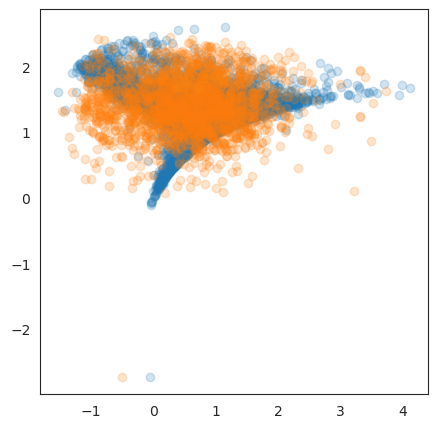

In [21]:
plt.scatter(df_good_v['bp_g'],df_good_v['g_rp'],alpha=0.2,)
plt.scatter(df_bad_v['bp_g'],df_bad_v['g_rp'],alpha=0.2)

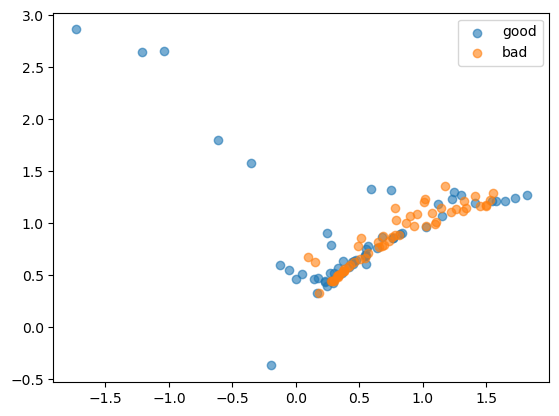

In [6]:
plt.scatter(df_good['bp_g'],df_good['g_rp'],alpha=0.6, label='good')
plt.scatter(df_bad['bp_g'],df_bad['g_rp'],alpha=0.6, label='bad')
plt.legend()

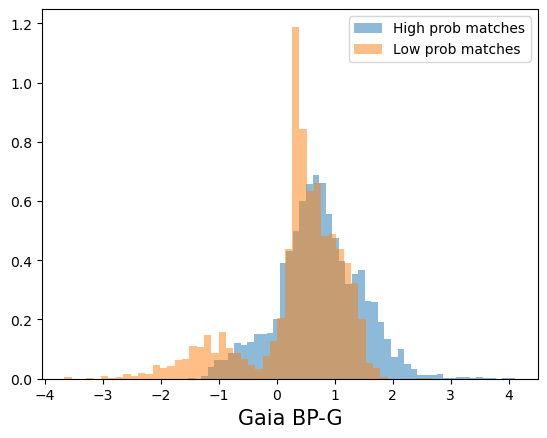

In [9]:
plt.hist(df_good['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

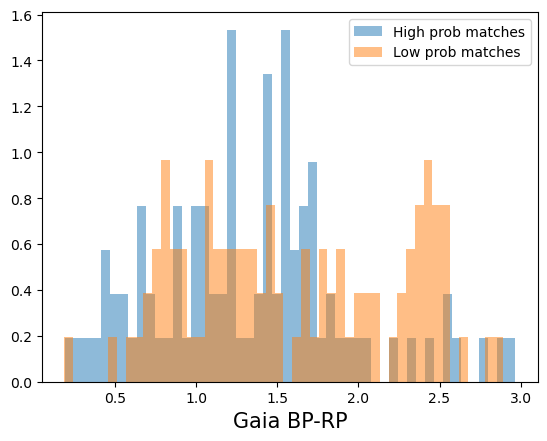

In [9]:
plt.hist(df_good['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


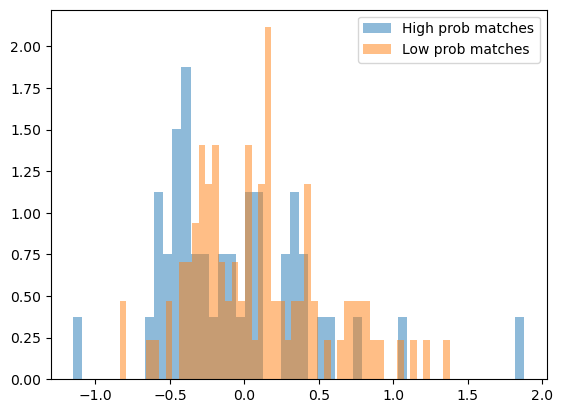

In [8]:
plt.hist(np.log10(1/df_good['parallax']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(1/df_bad['parallax']),bins=50,alpha=0.5,density=True,label='Low prob matches')
#plt.xlabel('Gaia G-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

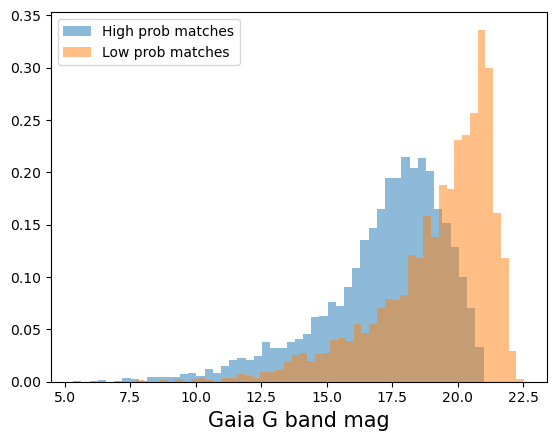

In [12]:
plt.hist(df_good['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

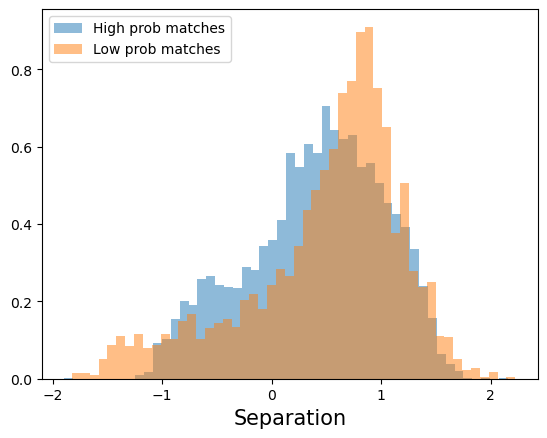

In [13]:
plt.hist(np.log10(100./df_good['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(100./df_bad['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Separation',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

<Axes: xlabel='g_rp', ylabel='phot_rp_mean_mag'>

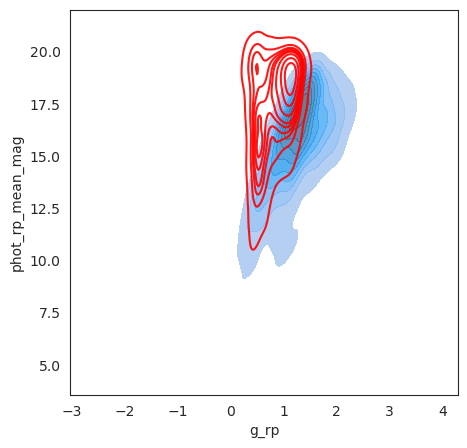

In [52]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.g_rp, y=df_good.phot_rp_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad.g_rp, y=df_bad.phot_rp_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9, color='red')
# plt.xlabel('Gaia BP-G',size=15)
# plt.ylabel('Gaia G mag',size=15)
#plt.savefig('figures/contour_with_mags_942023.pdf',dpi=300)

/tmp/ipykernel_28930/935819563.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,10e3)
/tmp/ipykernel_28930/935819563.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


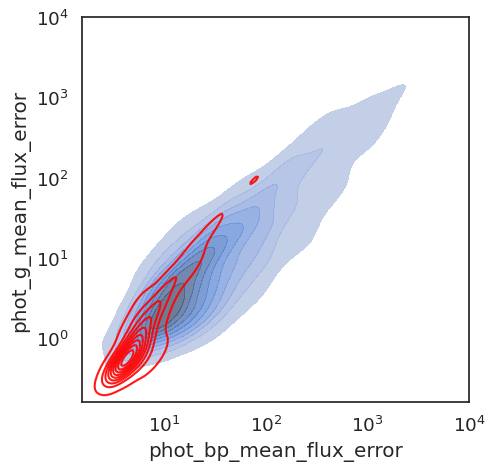

In [88]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.phot_bp_mean_flux_error, y=df_good.phot_g_mean_flux_error, label = 'High prob matches',fill=True,alpha=0.8, log_scale=True)
sns.kdeplot(x=df_bad.phot_bp_mean_flux_error, y=df_bad.phot_g_mean_flux_error, label = 'Low prob matches',fill=False,alpha=0.9, log_scale=True, color='red')
plt.xlim(0,10e3)
plt.ylim(0,10e3)
plt.savefig('figures/contour_g_bp_flux_errors.pdf', dpi=300)

Text(0, 0.5, 'Gaia G mag')

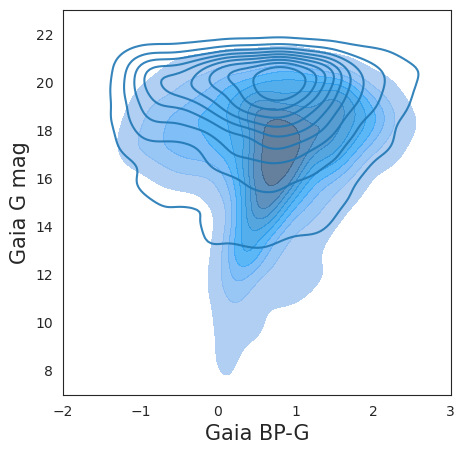

In [21]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good_v.bp_g, y=df_good_v.phot_g_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad_v.bp_g, y=df_bad_v.phot_g_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9)
plt.xlim(-2,3)
plt.ylim(7,23)
plt.xlabel('Gaia BP-G',size=15)
plt.ylabel('Gaia G mag',size=15)

---
#### Preprocessing

In [60]:
feature_names = [ 
    'phot_g_mean_flux', 
    'phot_g_mean_flux_error', 
    'phot_g_mean_flux_over_error', 
    'phot_bp_mean_flux', 
    'phot_bp_mean_flux_error', 
    'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_flux', 
    'phot_rp_mean_flux_error', 
    'phot_rp_mean_flux_over_error', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax', 
    'parallax_over_error'
]

#feature_names = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error']

# List of features to skip for the log transformation
skip_log_features = ['bp_rp', 'bp_g', 'g_rp']

## Random Feature
# Add random values to the DataFrame
# r = np.random.RandomState(42)
# df_good['random_feature'] = r.rand(len(df_good))
# df_bad['random_feature'] = r.rand(len(df_bad))

# # Add the random feature name to the feature names list
# feature_names.append('random_feature')
# skip_log_features.append('random_feature')

def transform_features(df):
    transformed_features = [
        np.log10(df[feature].values) if feature not in skip_log_features else df[feature].values
        for feature in feature_names
    ]
    return np.array(transformed_features).T

def preprocess(df_good, df_bad):
    # Transform features
    X_good = transform_features(df_good)
    X_bad = transform_features(df_bad)

    # Concatenate X and create Y labels
    X = np.concatenate((X_good, X_bad), axis=0)
    Y = np.concatenate((np.ones(len(X_good)), np.zeros(len(X_bad))), axis=0)

    return X, Y

def handle_missing_values(X_train, X_test):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    X_train = imp_mean.fit_transform(X_train)
    X_test = imp_mean.transform(X_test)
    return X_train, X_test, imp_mean

def standardize(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

In [61]:
# Preprocess the data
X, Y = preprocess(df_good_intersect, df_bad_intersect)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.4, shuffle=True)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
#X_train, X_test, scaler = standardize(X_train, X_test)

/tmp/ipykernel_915/2706941797.py:35: RuntimeWarning: invalid value encountered in log10
  np.log10(df[feature].values) if feature not in skip_log_features else df[feature].values


In [73]:
new_df_bad_to_test = transform_features(df_bad_to_test)
new_df_bad_to_test = imp_mean.transform(new_df_bad_to_test)
new_df_bad_to_test = scaler.transform(new_df_bad_to_test)

In [58]:
print(X_train.shape, X_test.shape)

(8069, 14) (3459, 14)


In [59]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {0.0: 0.5041516916594374, 1.0: 0.49584830834056265}
Test proportions: {0.0: 0.49031511997687194, 1.0: 0.5096848800231281}


In [62]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature phot_g_mean_flux: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_error: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_over_error: 0.00%
Percentage of NaN values in feature phot_bp_mean_flux: 29.01%
Percentage of NaN values in feature phot_bp_mean_flux_error: 29.01%
Percentage of NaN values in feature phot_bp_mean_flux_over_error: 29.01%
Percentage of NaN values in feature phot_rp_mean_flux: 29.07%
Percentage of NaN values in feature phot_rp_mean_flux_error: 29.07%
Percentage of NaN values in feature phot_rp_mean_flux_over_error: 29.07%
Percentage of NaN values in feature bp_rp: 29.10%
Percentage of NaN values in feature bp_g: 29.01%
Percentage of NaN values in feature g_rp: 29.07%
Percentage of NaN values in feature parallax: 20.67%
Percentage of NaN values in feature parallax_over_error: 20.67%


---
#### Baseline Models

In [ ]:
# Model Building
clf = LogisticRegression(max_iter=10000)  # max_iter may need to be increased depending on data convergence
clf.fit(X_train, Y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_prob))

#feature_importances = clf.coef_[0]
#for i, imp in enumerate(feature_importances):
#    print(f"{feature_names[i]}: Coefficient = {imp:.4f}")

In [68]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=4, max_features=6)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

# Check Scalar and Missing Values
# Error Analysis (check distances of matches in errors)

RF train accuracy: 0.776
Accuracy: 0.7394885132206328
Precision: 0.7057926829268293
Recall: 0.8115687992988606
F1 Score: 0.7549938850387282
AUC-ROC: 0.8197298418678207


In [ ]:

# Assuming clf_rf.predict(new_df_bad_to_test) gives you your prediction
predictions = clf_rf.predict(new_df_bad_to_test)

# Count the occurrence of each class in the prediction
unique, counts = np.unique(predictions, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Prediction')
for i, v in enumerate(class_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

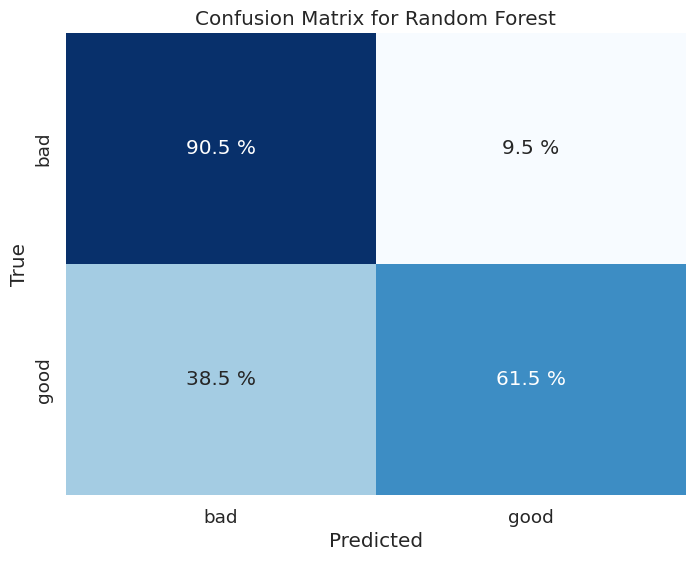

In [58]:
# Compute the confusion matrix and normalize it to get percentages
cm = confusion_matrix(Y_test, y_pred_rf, normalize='true')

# Multiply by 100 to get percentages and round to 1 decimal place
cm_percentage = (cm * 100).round(1)

# Define the class labels
class_labels = ['bad', 'good']

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Adjust to your preference
sns.heatmap(cm_percentage, annot=True, fmt='', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={'va':'center'},
            )

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')

# Iterate through the heatmap to add the '%' sign to the annotations
for t in plt.gca().texts:
    t.set_text(t.get_text() + " %")

#plt.savefig('figures/confusion_rf_.png', dpi=300)

/tmp/ipykernel_155577/1477544901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = y_pred_rf
/tmp/ipykernel_155577/1477544901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['actual'] = Y_test
/tmp/ipykernel_155577/1477544901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

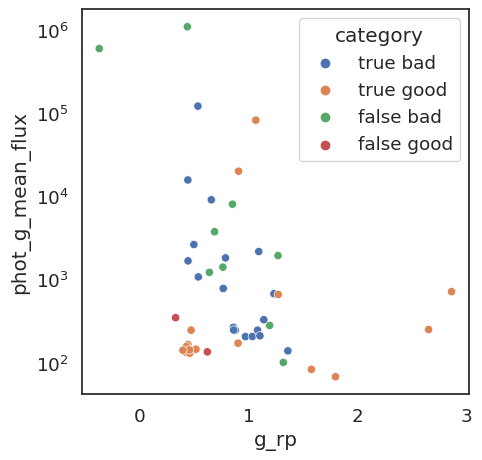

In [60]:
# Concatenate good and bad datasets to refer back later
df_test = df_all.iloc[indices_test]

# Add predictions and actual labels
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

#df_test = df_test.query('separation <=0.2 and parallax >=0')
# Define categories based on predictions and actual labels
df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
                                                  'true bad' if row['prediction'] == row['actual'] == 0 else 
                                                  'false good' if row['prediction'] == 1 else 'false bad', axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
#                                                   'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false good' if row['prediction'] == 1 and row['actual'] == 0 else None, axis=1)

# Plot
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")


sns.scatterplot(data = df_test, x='g_rp', y='phot_g_mean_flux', 
            hue='category')
plt.yscale('log')

plt.show()


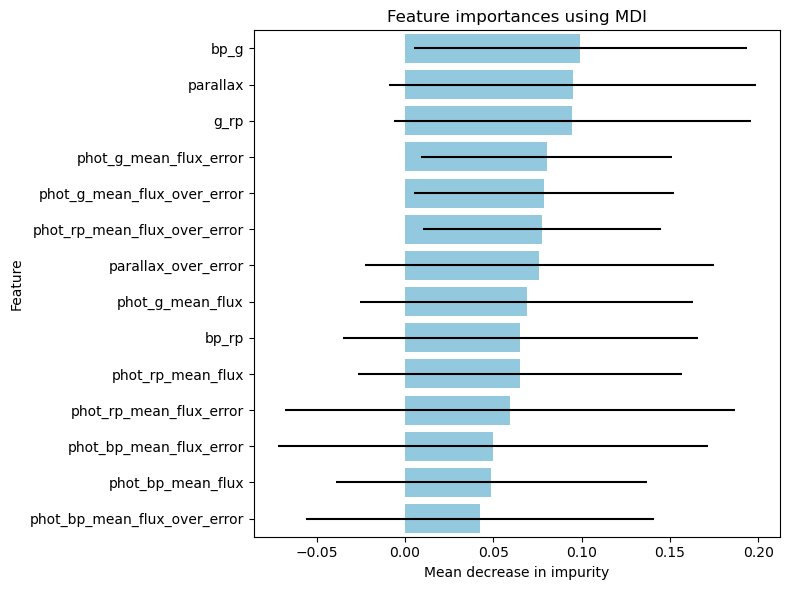

In [38]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': forest_importances.index, 'Importance': forest_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, xerr=std, color='skyblue')
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()
#plt.savefig('figures/importances_rf_8202023.pdf', dpi=300)

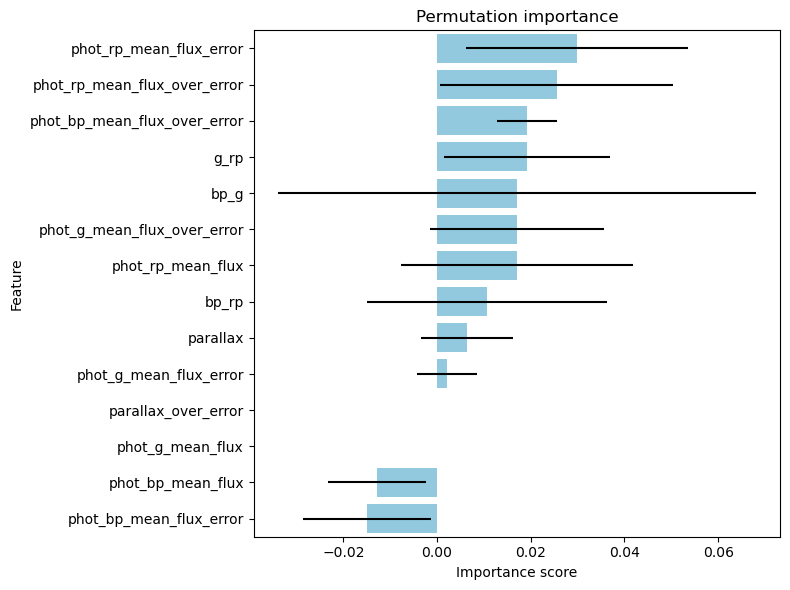

In [48]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()
#plt.savefig('importances_rf_942023.pdf')


In [ ]:
# Model Building
clf_svm = SVC(kernel='linear', probability=True, random_state=42)  # Using 'linear' kernel as a baseline. Probability is True for AUC-ROC.
clf_svm.fit(X_train, Y_train)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_prob = clf_svm.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_svm_prob))

#### NN

In [19]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(15,)))
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(1, activation='sigmoid'))

In [20]:
Adagrad = optimizers.Adagrad(learning_rate=0.005)
network.compile(optimizer=Adagrad,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
#optimizer.lr.set_value(0.02)

In [22]:
history = network.fit(X_train, Y_train, validation_split=0.2, epochs=200, batch_size=256, verbose=False)

In [23]:
network.save('models/model2_2082023.h5')

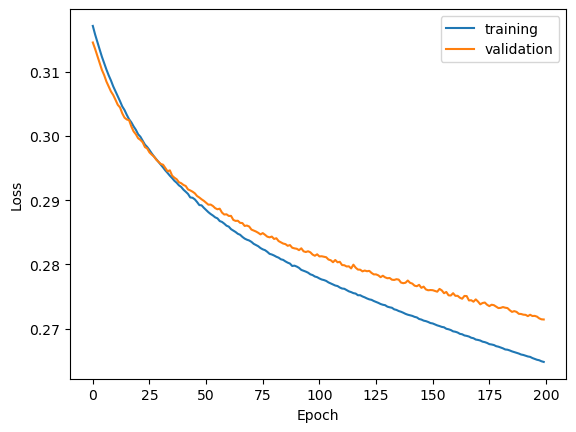

In [24]:
# 200, don't stop until overtfit. 
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('models/loss_nn2_random.pdf')

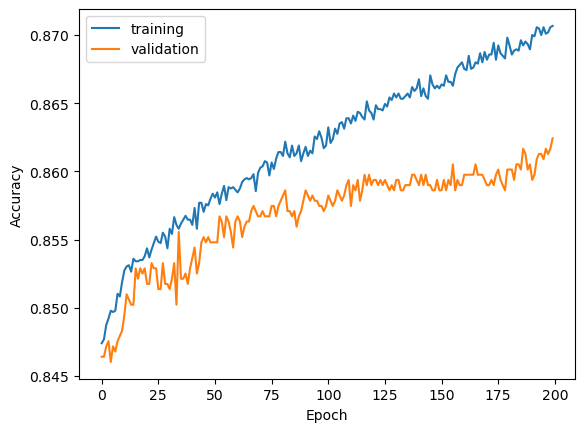

In [25]:
plt.plot(history.history['binary_accuracy'],label='training')
plt.plot(history.history['val_binary_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('figures/acc_nn2_random.pdf')

In [26]:
print('\n# Evaluate on test data')
results = network.evaluate(X_test, Y_test, batch_size=256)
print('test loss, test acc:', results)


# Evaluate on test data
22/22 [==============================] - 0s 8ms/step - loss: 0.2668 - binary_accuracy: 0.8645
test loss, test acc: [0.26681530475616455, 0.8644610643386841]


In [27]:
# Predict probabilities for the test set
y_pred_probs = network.predict(X_test).ravel()

# Convert probabilities to class labels (0 or 1) using a threshold, typically 0.5 for binary classification
y_pred_label = (y_pred_probs > 0.5).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(Y_test, y_pred_label)
recall = recall_score(Y_test, y_pred_label)
f1 = f1_score(Y_test, y_pred_label)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Display metrics
print('\n# Extended Evaluation Metrics')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', roc_auc)


176/176 [==============================] - 1s 5ms/step

# Extended Evaluation Metrics
Precision: 0.7455310199789695
Recall: 0.8360849056603774
F1 Score: 0.7882156753752084
AUC: 0.9414277638673959


In [32]:
# Compute permutation importance
importances = compute_permutation_importance(clf_rf, X_test, Y_test)

# Display the importances
for i, imp in enumerate(importances):
    print(f"{feature_names[i]}: Importance = {imp:.4f}")

phot_g_mean_flux: Importance = 0.0000
phot_g_mean_flux_error: Importance = 0.1347
phot_g_mean_flux_over_error: Importance = 0.0053
phot_bp_mean_flux: Importance = 0.0000
phot_bp_mean_flux_error: Importance = 0.0053
phot_bp_mean_flux_over_error: Importance = 0.0044
phot_rp_mean_flux: Importance = -0.0004
phot_rp_mean_flux_error: Importance = 0.0291
phot_rp_mean_flux_over_error: Importance = 0.0035
bp_rp: Importance = 0.0004
bp_g: Importance = 0.0009
g_rp: Importance = 0.0031
parallax: Importance = 0.0013
parallax_over_error: Importance = 0.0009


In [ ]:
nn_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': nn_importances.index, 'Importance': nn_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title("Feature importances using permutation importance (NN)")
plt.xlabel("Importance score")
plt.tight_layout()
#plt.savefig('figures/importances_nn_random.pdf', dpi=300)